Code to create the z maps for second level models (1 per session, across subj) for each task/contrast

And also to visualize them

In [15]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import warnings
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# format:
# /oak/stanford/groups/russpold/data/network_grant/discovery_BIDS_20250402/derivatives/output_lev1_mni/sub-s03/nBack/indiv_contrasts
# sub-s03_ses-02_task-nBack_contrast-twoBack-oneBack_rtmodel-rt_centered_stat-effect-size.nii.gz
BASE_DIR = '/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS_20250402/derivatives/'
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']
SESSIONS = ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09','ses-10']
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
LEVEL = 'output_lev1_mni'
max_encounter_num = 5

# make/get folder where zmap niftis are saved
OUTPUT_LEVEL = 'output_lev2_mni'
# OUTPUT_DIR = os.path.join(BASE_DIR,OUTPUT_LEVEL,'zmaps')
# os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_DIR = '/home/users/nklevak/network_data/'
os.makedirs(OUTPUT_DIR, exist_ok=True)


CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline", "incongruent-congruent","response_time"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

# Lists to store contrast maps and design information
all_contrast_maps = {}
session_maps = {} # to keep track of them per subj (to normalize the order)
design_matrix_rows = []

In [3]:
for task in TASKS:
    session_maps[task]={}
    all_contrast_maps[task] = []
    
    for contrast_name in CONTRASTS[task]:
        session_maps[task][contrast_name] = {}
        
        # save the first level contrast map files
        for subject in SUBJECTS:
            overall_session_count = 0
            session_maps[task][contrast_name][subject] = {}

            for session in SESSIONS:
                # Path to contrast image from first-level analysis
                contrast_map_path = os.path.join(
                    BASE_DIR, LEVEL, subject, task, 'indiv_contrasts', f'{subject}_{session}_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
                )
                
                # Check if file exists before adding
                if os.path.exists(contrast_map_path):
                    all_contrast_maps[task].append(contrast_map_path)
                    
                    session_maps[task][contrast_name][subject][overall_session_count] = contrast_map_path
                    overall_session_count += 1

In [4]:
# sort the contrast maps per objective encounter number
session_contrast_maps = {}
session_design_rows = {}

for task in TASKS:
    session_contrast_maps[task] = {}
    session_design_rows[task] = {}
    
    for contrast_name in CONTRASTS[task]:
        session_contrast_maps[task][contrast_name] = {}
        session_design_rows[task][contrast_name] = {}
    
        for encounter in range(max_encounter_num):
            session_contrast_maps[task][contrast_name][encounter] = []
            session_design_rows[task][contrast_name][encounter] = []
            
            for subject in SUBJECTS:
                subject_numeric = np.float64(float(subject[5:]))
                
                if subject in session_maps[task][contrast_name] and encounter in session_maps[task][contrast_name][subject]:
                    map = session_maps[task][contrast_name][subject][encounter]
                    session_contrast_maps[task][contrast_name][encounter].append(map)
                    session_design_rows[task][contrast_name][encounter].append({
                        'subject': subject_numeric,
                        # Add any subject-specific covariates here
                        # 'age': subject_age[subject],
                        # 'performance': n_back_performance[subject][session]
                    })

In [16]:
# make and save all of the second level models zmaps (1 per session)
secondLevelZmaps = {}

for task in TASKS:
    secondLevelZmaps[task] = {}
    
    for contrast_name in CONTRASTS[task]:
        secondLevelZmaps[task][contrast_name] = {}
        
        for encounter in range(5):
            # # get the design matrix for given session
            # dm = pd.DataFrame(session_design_rows[task][contrast_name][encounter])
            # # Add intercept column (group effect)
            # dm['intercept'] = 1
        
            # contrast_maps = [nib.load(cm) for cm in session_contrast_maps[task][contrast_name][encounter]]
            
            # second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
            # second_level_model.fit(contrast_maps, design_matrix=dm)
        
            # z_map = second_level_model.compute_contrast(
            #     second_level_contrast='intercept',
            #     output_type='z_score'
            # )
        
            # secondLevelZmaps[task][contrast_name][encounter] = z_map

            # Skip if fewer than minimum required subjects
            if len(session_contrast_maps[task][contrast_name][encounter]) < 4:
                print(f"Skipping {task}:{contrast_name}:encounter-{encounter+1} (insufficient data)")
                secondLevelZmaps[task][contrast_name][encounter] = None
                continue
                
            try:
                # get the design matrix for given session
                dm = pd.DataFrame(session_design_rows[task][contrast_name][encounter])
                # Add intercept column (group effect)
                dm['intercept'] = 1
                
                # Check for design matrix issues
                if dm.shape[0] <= dm.shape[1]:
                    print(f"Warning: More regressors than subjects for {task}:{contrast_name}:encounter-{encounter+1}")
                
                # Filter out any all-zero/constant maps
                valid_maps = []
                valid_rows = []
                
                for i, cm_path in enumerate(session_contrast_maps[task][contrast_name][encounter]):
                    img = nib.load(cm_path)
                    data = img.get_fdata()
                    # Check if map has sufficient variance
                    if np.std(data) > 1e-10 and not np.isnan(data).any():
                        valid_maps.append(img)
                        valid_rows.append(dm.iloc[i])
                
                if len(valid_maps) < 4:
                    print(f"Skipping {task}:{contrast_name}:encounter-{encounter+1} (insufficient valid maps)")
                    secondLevelZmaps[task][contrast_name][encounter] = None
                    continue
                
                # Recreate design matrix with only valid subjects
                valid_dm = pd.DataFrame(valid_rows).reset_index(drop=True)
                
                # Use mask_img to restrict analysis to non-zero voxels
                # This can help avoid divide-by-zero errors
                second_level_model = SecondLevelModel(
                    smoothing_fwhm=8.0,
                    # Optional: Use explicit mask to exclude problematic voxels
                    # mask_img=compute_group_mask(valid_maps)
                )
                
                # Suppress specific warnings for this operation
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=RuntimeWarning)
                    second_level_model.fit(valid_maps, design_matrix=valid_dm)
                
                # Compute the group effect with minimized warnings
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", category=RuntimeWarning)
                    z_map = second_level_model.compute_contrast(
                        second_level_contrast='intercept',
                        output_type='z_score'
                    )
                
                # Check if the resulting z-map contains NaNs or infinities
                data = z_map.get_fdata()
                if np.isnan(data).any() or np.isinf(data).any():
                    # Replace NaNs and infinities with zeros for practical use
                    data = np.nan_to_num(data)
                    z_map = nib.Nifti1Image(data, z_map.affine, z_map.header)
                    print(f"Warning: Fixed NaN/Inf values in {task}:{contrast_name}:encounter-{encounter+1}")
                
                secondLevelZmaps[task][contrast_name][encounter] = z_map
                print(f"Completed {task}:{contrast_name}:encounter-{encounter+1}")
                
            except Exception as e:
                print(f"Error processing {task}:{contrast_name}:encounter-{encounter+1}: {e}")
                secondLevelZmaps[task][contrast_name][encounter] = None

Completed nBack:twoBack-oneBack:encounter-1
Completed nBack:twoBack-oneBack:encounter-2
Completed nBack:twoBack-oneBack:encounter-3
Completed nBack:twoBack-oneBack:encounter-4
Completed nBack:twoBack-oneBack:encounter-5
Completed nBack:match-mismatch:encounter-1
Completed nBack:match-mismatch:encounter-2
Completed nBack:match-mismatch:encounter-3
Completed nBack:match-mismatch:encounter-4
Completed nBack:match-mismatch:encounter-5
Completed nBack:task-baseline:encounter-1
Completed nBack:task-baseline:encounter-2
Completed nBack:task-baseline:encounter-3
Completed nBack:task-baseline:encounter-4
Completed nBack:task-baseline:encounter-5
Completed nBack:response_time:encounter-1
Completed nBack:response_time:encounter-2
Completed nBack:response_time:encounter-3
Completed nBack:response_time:encounter-4
Completed nBack:response_time:encounter-5
Completed flanker:incongruent-congruent:encounter-1
Completed flanker:incongruent-congruent:encounter-2
Completed flanker:incongruent-congruent:e

In [25]:
# save the second level zmaps to a folder

# Create a function to save zmaps with metadata
def save_zmaps_with_metadata(zmaps_dict, output_dir=OUTPUT_DIR):
    """
    Save zmaps with corresponding metadata json files in BIDS-like format.
    
    Parameters:
    -----------
    zmaps_dict : dict
        Nested dictionary of zmaps organized by task, contrast, and encounter.
    output_dir : str
        Directory where files will be saved.
    """
    # Get current date for metadata
    current_date = datetime.datetime.now().strftime('%Y-%m-%d')

    num_saved = 0
    num_skipped = 0
    for task in zmaps_dict:
        # Create task directory
        task_dir = os.path.join(output_dir, task)
        os.makedirs(task_dir, exist_ok=True)
        
        for contrast_name in zmaps_dict[task]:
            # Create contrast directory
            contrast_dir = os.path.join(task_dir, contrast_name)
            os.makedirs(contrast_dir, exist_ok=True)
            
            for encounter_idx, zmap in zmaps_dict[task][contrast_name].items():
                # Define base filename
                base_filename = f"{task}_{contrast_name}encounter{encounter_idx+1}"
                full_path = os.path.join(contrast_dir, base_filename)

                try:
                    # Save NIfTI file
                    zmap.to_filename(f"{full_path}.nii.gz")
                    num_saved += 1
                    
                    # Create and save metadata
                    metadata = {
                        "TaskName": task,
                        "ContrastName": contrast_name,
                        "EncounterNumber": encounter_idx + 1,
                        "DataType": "z_statistic_map",
                        "AnalysisDate": current_date,
                        "SmoothinFWHM": 8.0,  # From model
                        "ContrastType": "intercept",  # From contrast
                        "OutputType": "z_score"  # From output type
                    }
    
                    # Save metadata to JSON file
                    with open(f"{full_path}.json", 'w') as f:
                        json.dump(metadata, f, indent=4)
                except Exception as e:
                    print(f"Error saving {task}:{contrast_name}:encounter-{encounter_idx+1}: {e}")
                    num_skipped += 1
                
    print(f"Saved {num_saved} zmaps with metadata. Skipped {num_skipped} maps.")
# save updated zmaps to folder
save_zmaps_with_metadata(secondLevelZmaps)

Error saving goNogo:nogo_success-go:encounter-5: 'NoneType' object has no attribute 'to_filename'
Error saving goNogo:nogo_success:encounter-5: 'NoneType' object has no attribute 'to_filename'
Error saving goNogo:task-baseline:encounter-5: 'NoneType' object has no attribute 'to_filename'
Error saving goNogo:response_time:encounter-5: 'NoneType' object has no attribute 'to_filename'
Saved 211 zmaps with metadata. Skipped 4 maps.


In [26]:
# load in the zmaps from the directory (optional)
def load_zmaps_with_metadata(input_dir):
    """
    Load z-statistic maps and their metadata from a BIDS-like directory structure.
    
    Parameters:
    -----------
    input_dir : str
        Directory where files were saved.
        
    Returns:
    --------
    dict
        Nested dictionary containing loaded zmaps and metadata, organized by task, contrast, and encounter.
    """
    # Initialize nested defaultdict to store the loaded data
    loaded_data = defaultdict(lambda: defaultdict(dict))
    
    # Track number of files loaded
    num_files_loaded = 0
    
    # Walk through the directory structure
    for task_name in os.listdir(input_dir):
        task_dir = os.path.join(input_dir, task_name)
        
        # Skip if not a directory
        if not os.path.isdir(task_dir):
            continue
            
        for contrast_name in os.listdir(task_dir):
            contrast_dir = os.path.join(task_dir, contrast_name)
            
            # Skip if not a directory
            if not os.path.isdir(contrast_dir):
                continue
                
            # Find all .nii.gz files in this contrast directory
            for filename in os.listdir(contrast_dir):
                if filename.endswith('.nii.gz'):
                    # Extract base filename without extension
                    base_filename = filename.replace('.nii.gz', '')
                    
                    # Check if corresponding JSON metadata exists
                    json_path = os.path.join(contrast_dir, f"{base_filename}.json")
                    if not os.path.exists(json_path):
                        print(f"Warning: No metadata found for {filename}")
                        continue
                    
                    # Load the image
                    img_path = os.path.join(contrast_dir, filename)
                    zmap = nib.load(img_path)
                    
                    # Load the metadata
                    with open(json_path, 'r') as f:
                        metadata = json.load(f)
                    
                    # Get encounter index (0-based)
                    encounter_idx = metadata["EncounterNumber"] - 1
                    
                    # Store both the image and metadata
                    loaded_data[task_name][contrast_name][encounter_idx] = {
                        'zmap': zmap,
                        'metadata': metadata
                    }
                    
                    num_files_loaded += 1
    
    print(f"Loaded {num_files_loaded} z-statistic maps with metadata.")
    return loaded_data


loaded_zmaps = load_zmaps_with_metadata(OUTPUT_DIR)

Loaded 211 z-statistic maps with metadata.


In [27]:
print(loaded_zmaps)

defaultdict(<function load_zmaps_with_metadata.<locals>.<lambda> at 0x7f0422636700>, {'cuedTS': defaultdict(<class 'dict'>, {'task_switch_cost': {0: {'zmap': <nibabel.nifti1.Nifti1Image object at 0x7f0422733bb0>, 'metadata': {'TaskName': 'cuedTS', 'ContrastName': 'task_switch_cost', 'EncounterNumber': 1, 'DataType': 'z_statistic_map', 'AnalysisDate': '2025-05-01', 'SmoothinFWHM': 8.0, 'ContrastType': 'intercept', 'OutputType': 'z_score'}}, 2: {'zmap': <nibabel.nifti1.Nifti1Image object at 0x7f0422733940>, 'metadata': {'TaskName': 'cuedTS', 'ContrastName': 'task_switch_cost', 'EncounterNumber': 3, 'DataType': 'z_statistic_map', 'AnalysisDate': '2025-05-01', 'SmoothinFWHM': 8.0, 'ContrastType': 'intercept', 'OutputType': 'z_score'}}, 1: {'zmap': <nibabel.nifti1.Nifti1Image object at 0x7f0420ec3c10>, 'metadata': {'TaskName': 'cuedTS', 'ContrastName': 'task_switch_cost', 'EncounterNumber': 2, 'DataType': 'z_statistic_map', 'AnalysisDate': '2025-05-01', 'SmoothinFWHM': 8.0, 'ContrastType': 

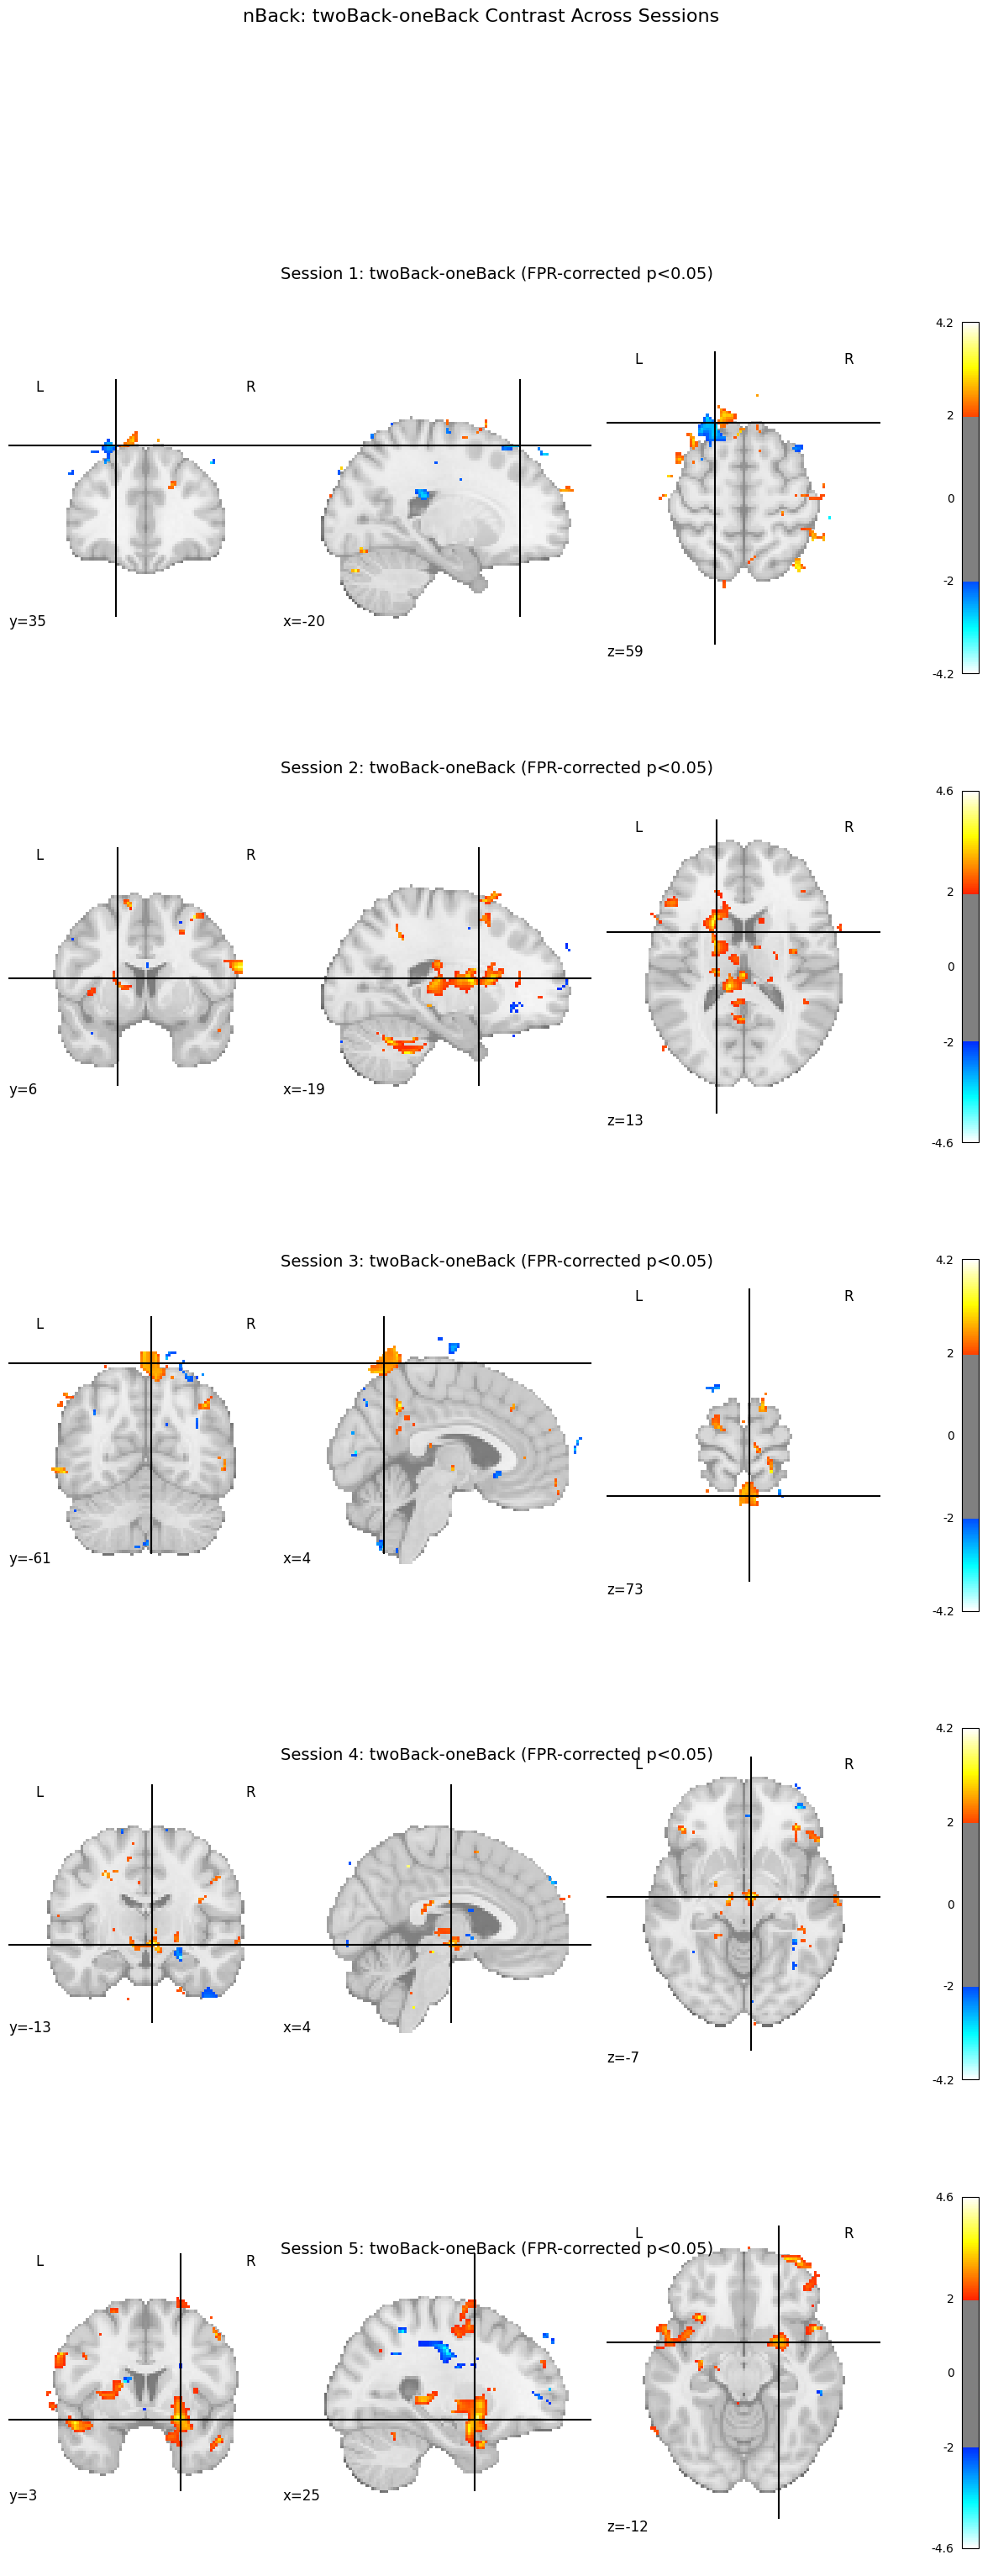

In [28]:
def visualize_thresholded_zmaps(loaded_zmaps, task_name, contrast_name, 
                               alpha=0.05, height_control='fpr', 
                               display_mode='ortho', output_dir=None, threshold_enact=True):
    """
    Visualize and threshold z-statistic maps from loaded data.
    
    Parameters:
    -----------
    loaded_zmaps : dict
        Nested dictionary structure with loaded zmaps
    task_name : str
        Name of the task to visualize
    contrast_name : str
        Name of the contrast to visualize
    alpha : float, default=0.05
        Significance level for thresholding
    height_control : str, default='fpr'
        Multiple comparison correction method ('fpr', 'fdr', 'bonferroni')
    display_mode : str, default='ortho'
        Display mode for brain visualization
    output_dir : str, optional
        Directory to save visualizations. If None, figures are not saved.
    threshold_enact : boolean, optional
        Should it be thresholded at all
    """
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Extract the contrast maps for the specified task and contrast
    contrast_maps = {}
    if task_name in loaded_zmaps and contrast_name in loaded_zmaps[task_name]:
        contrast_data = loaded_zmaps[task_name][contrast_name]
        # Sort by encounter number to ensure visualization in order
        for encounter_idx in sorted(contrast_data.keys()):
            contrast_maps[encounter_idx] = contrast_data[encounter_idx]['zmap']
    else:
        print(f"No data found for task '{task_name}' and contrast '{contrast_name}'")
        return
    
    # Create a figure with appropriate dimensions
    plt.figure(figsize=(15, 35))  # Make figure taller and wider
    
    # Process each map
    for i, (encounter_idx, zmap) in enumerate(contrast_maps.items()):
        # Create subplot BEFORE any visualization
        ax = plt.subplot(5, 1, i+1)  # Fixed: i+1 instead of encounter+1
        
        # Get encounter number from metadata for title
        encounter_num = loaded_zmaps[task_name][contrast_name][encounter_idx]['metadata']['EncounterNumber']
        
        if threshold_enact:
            # Threshold the statistical map
            thresholded_map, threshold = threshold_stats_img(
                zmap, alpha=alpha, height_control=height_control
            )
        else:
            thresholded_map = zmap
            threshold = 0
            
        # Plot thresholded map WITH axes parameter
        display = plotting.plot_stat_map(
            thresholded_map,
            threshold=threshold,
            display_mode=display_mode,
            cut_coords=None,
            colorbar=True,
            axes=ax,
            # title=None  # Don't let nilearn add a title
        )

        if threshold_enact:
            # Set title with proper padding after visualization
            ax.set_title(f'Session {encounter_num}: {contrast_name} ({height_control.upper()}-corrected p<{alpha})', 
                        pad=20,
                        fontsize=14)
        else:
            # Set title with proper padding after visualization
            ax.set_title(f'Session {encounter_num}: {contrast_name} unthresholded', 
                    pad=20,
                    fontsize=14)

    
    # Adjust layout - AFTER all plotting is done
    # plt.subplots_adjust(hspace=0.7, top=0.3, bottom=0.02)
    
    # Add main title
    plt.suptitle(f'{task_name}: {contrast_name} Contrast Across Sessions', 
                fontsize=16, y=0.98)
    
    # Save figure if output directory is specified
    if output_dir:
        filename = f"{task_name}_{contrast_name}_thresholded.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {os.path.join(output_dir, filename)}")
        
    plt.subplots_adjust(hspace=0.7)  # Increased spacing between plots
    plt.show()

task = 'nBack'
contrast = 'twoBack-oneBack'
visualize_thresholded_zmaps(loaded_zmaps, task, contrast, 
                           alpha=0.05, height_control='fpr',threshold_enact=True)

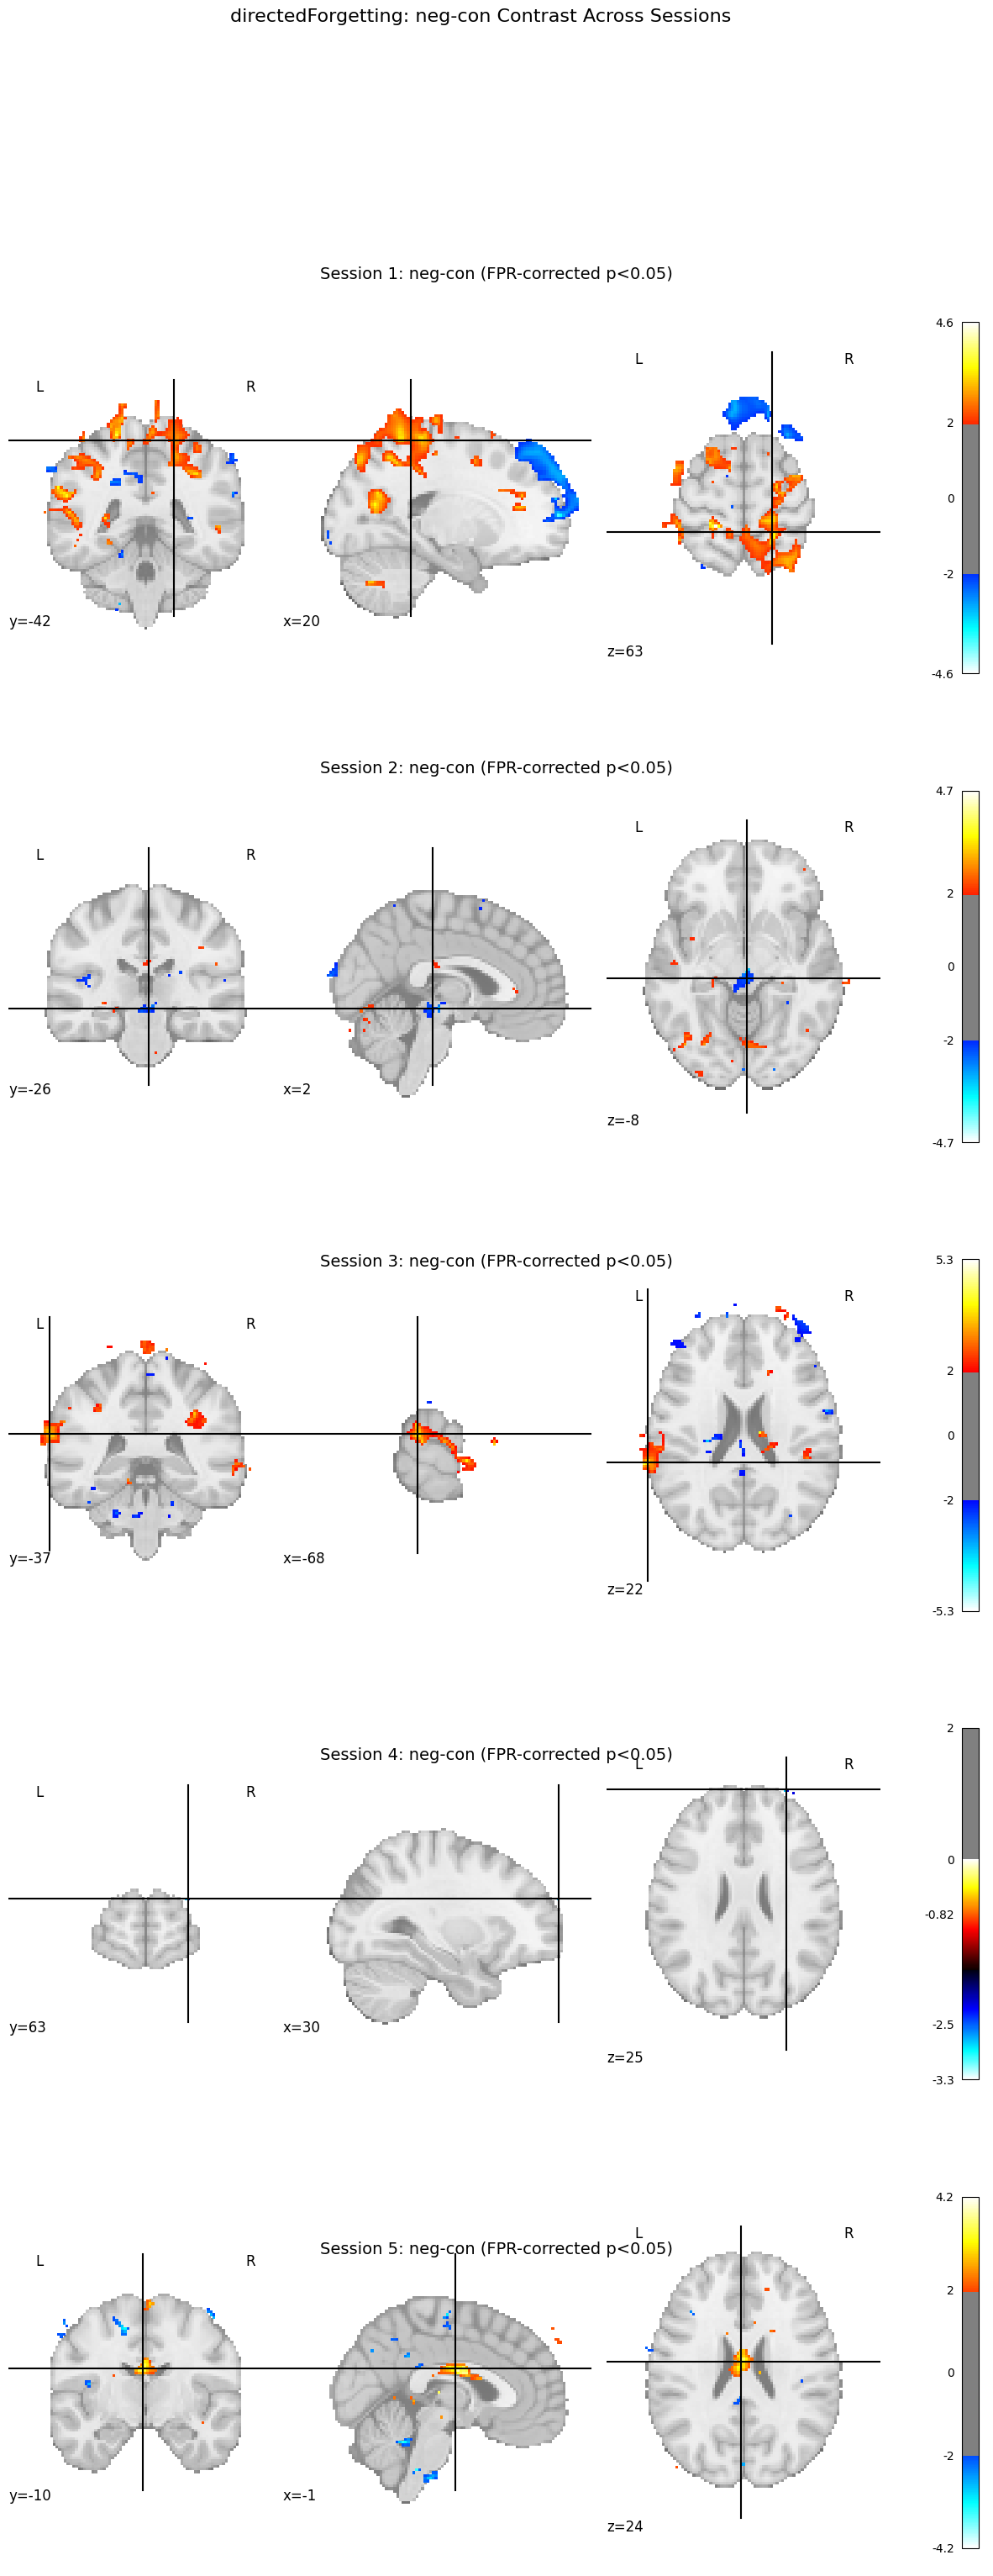

In [30]:
task = 'directedForgetting'
contrast = 'neg-con'
visualize_thresholded_zmaps(loaded_zmaps, task, contrast, 
                           alpha=0.05, height_control='fpr',threshold_enact=True)